<a href="https://colab.research.google.com/github/simon-clematide/casdmit-fs21/blob/master/notebooks/impresso_lid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sprachidentifikation mit fasttext
Dieses Notebook demonstriert, wie einfach man ein gutes LID-Modell mit fastText trainieren kann.
Wir arbeiten mit der fasttext Python-Bibliothek.
Aus Effizienzgründen arbeiten wir hier mit einem kleineren Trainingsdatensatz.

# Installation
## Nur notwendig, wenn nicht in colab/binder VM
Conda-Umgebung mit FastText bereitstellen im Terminal und dann Jupyter Notebook nochmals starten.

```bash
conda activate base
conda create --name lid --clone base
conda activate lid
conda install -c conda-forge fasttext
# danach neues Terminal öffnen und conda aktivieren

# fasttext Python Modul installieren
# pip install fasttext # hat Bug bei test_label()
pip install git+https://github.com/facebookresearch/fastText.git@b64e359d5485dda4b4b5074494155d18e25c8d13  # braucht mehr Zeit fürs Kompilieren

# danach Jupyter neu starten
jupyter notebook
```

# In colab das Python fasttext Package installieren
Aktuellere Version hat [Bug](https://stackoverflow.com/questions/61787119/fasttext-0-9-2-why-is-recall-nan) in der fasttext Evaluationsfunktion korrigiert. Wir verwenden aber unsere eigene Evaluation

In [48]:
! pip install fasttext # schnell zu installieren, aber hat Bug bei test_label()
#! pip install git+https://github.com/facebookresearch/fastText.git@b64e359d5485dda4b4b5074494155d18e25c8d13  # braucht mehr Zeit fürs Kompilieren

# Datenset

In [49]:
! curl https://files.ifi.uzh.ch/cl/siclemat/lehre/fs21/casdmit/impresso-lid/impresso-lid.tsv -o impresso-lid.tsv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  382k  100  382k    0     0   327k      0  0:00:01  0:00:01 --:--:--  327k


### Format des Datensets
 - Pro tabulator-separierte Zeile gibt es 2 Spalten
 - Spalte 1: Sprachlabel
 - Spalte 2: Textstücke (ca. 400 Buchstaben)

In [50]:
! head -n 10 impresso-lid.tsv

__label__fr	Phoenix Bergban ... . . —it Siemens Halske . . . V» Ve Internat. Bank Ltuemb. — _ _ Deutsche Bank.. . . . . . °, Dresdncr Bank . . . . .— y« Discontc-Gesellschaft: . .— . so/* Berliner Handelsges. . . . \“la Rdchsbank. .- .
__label__lb	Den englesche plang fir Palestina Den englesche plang fir Palestina get den arabeschen delegatio'nen an der jüddescher agence virgeluegt. No gewessen informatio'nen soll dese plang follgend ponkten emfâssen: . Schafong vun cantonen. e jüddeschen an en arabeschen. . Dreiparteien-centralregirong zu Jerusalem. . Drei dietricter zu Jerusalem, e jüddeschen, en arabeschen an e klengeren fir 'Araber müss
__label__de	oie »or regeln formte ; nur müßte unfer SKilttärtocfen »oüfiänbiger unb foftjpteliger toerben unb mügten »ir benÄönig »on al« oberften Ärieg«berrn aners ïenr.en. Bir geben ju, bag ba« Sanb bei ginfüb= rung ber beutfdjen $anbel«gefeggebung, be« beutfdjen tyofc unb ïelegrapbenœefen« «. f. »., toie lrt. be« SJÎeformprojefte« fagt, getttnnen

### Statistiken zum Datenset

In [51]:
! wc impresso-lid.tsv

  1000  60519 391400 impresso-lid.tsv


In [52]:
!  cut -f 1 < impresso-lid.tsv | sort | uniq -c | sort -rn

    577 __label__de
    306 __label__fr
     57 __label__lb
     33 __label__en
     27 __label__it


## Aufteilen der Daten in Trainings- und Testdaten
Erstellen von Training und Testdaten (Originaldaten sind zufällig geordnet)

In [53]:
! head -n 900 < impresso-lid.tsv > impresso-lid-train.tsv
! tail -n 100 < impresso-lid.tsv > impresso-lid-test.tsv

In [54]:
! echo TRAINING DATA STATISTICS
! cut -f 1 < impresso-lid-train.tsv | sort | uniq -c | sort -rn
! echo TEST DATA STATISTICS
! cut -f 1 < impresso-lid-test.tsv | sort | uniq -c | sort -rn

TRAINING DATA STATISTICS
    518 __label__de
    278 __label__fr
     51 __label__lb
     31 __label__en
     22 __label__it
TEST DATA STATISTICS
     59 __label__de
     28 __label__fr
      6 __label__lb
      5 __label__it
      2 __label__en


# Trainieren von Modell mit Python-Package
 - Dokumentation siehe https://fasttext.cc/docs/en/python-module.html

In [55]:
import fasttext

In [56]:
model = fasttext.train_supervised(
    input='impresso-lid-train.tsv',
    epoch=10,  # Wie oft werden die Trainingsdaten benutzt
    minn=2,    # Minimal Subword-Länge in Buchstaben
    maxn=2,    # Maximale Subword-Länge in Buchstaben
    dim=5,     # Dimensionalität der Vektoren für die Repräsentation der Wörter und Subwords
    lr=0.1     # Learning Rate (Lernrate): Wie stark wird ein Fehler bestraft?
    )

## Inspizieren des gelernten Modells

Welche Labels/Klassen kennt das Modell?

In [57]:
print(model.labels)

['__label__de', '__label__fr', '__label__lb', '__label__en', '__label__it']


Einen String klassifizieren und die Wahrscheinlichkeitsverteilung über allen möglichen Sprachen erhalten:

In [58]:
model.predict("Welche Sprache ist das? Luxemburgisch?",
              k=5  # Gib die 5 besten Klassen aus
              )


(('__label__de', '__label__fr', '__label__lb', '__label__en', '__label__it'),
 array([0.63970125, 0.23558697, 0.0601043 , 0.03515252, 0.02950506]))

Den gelernten Vektor eines Worts anzeigen.

In [59]:
word_id = model.get_word_id("Sprache")
print(word_id)
model.get_input_vector(word_id)

16199


array([ 0.1948833 ,  0.13617264,  0.13072939,  0.14742012, -0.18970487],
      dtype=float32)

Ids von Wort und allen seinen Buchstaben-N-Grammen erhalten.

In [60]:
model.get_subwords('Sprache')

(['Sprache', '<S', 'Sp', 'pr', 'ra', 'ac', 'ch', 'he', 'e>'],
 array([  16199, 1920969, 1366119, 1001592, 1066093, 1075118,  588831,
        1388807,  484043]))

Was passiert hier?

In [61]:
model.get_subwords('???')

(['<?', '??', '??', '?>'], array([1694301,  409332,  409332, 1631713]))

Systematisches Testen des Minimodells auf Testdaten

## Vorhersagen und Wahrheit anzeigen

In [66]:
test_data = []
with open("impresso-lid-test.tsv", mode="r",encoding="utf-8") as testfile:
    for line in testfile:
        test_data.append(line.strip().split("\t"))
test_data[:3]


[['__label__fr',
  'dans cette pensée. Qu\'est-ce qu\'une égalité apparente et toute fondé sur ce qui nous échappe chaque jour, à côté de la noblesse permanente et accessible à tous les enfants de Dieu? Comme on l\'a dit de la Suisse, notre être ne peut grandir que du côté du ciel. Soyons des valeurs: notre foi nous y invite, car notre Maître a dit: „Soyez parfaits ..." et nous n\'aurons rien à envier aux autres. G.'],
 ['__label__fr',
  'LIGNE DU NORD. MAT. MAT. LOIR. LOIR. LOIR. M. MAT. MAT. MAT. LOIR. LM.IA.DP. IS IS T IUJ OOLOYN. DTP. J DOMMALDANGA T IS ST S» AIA-LA-OHAP. J J WFTLF.RD.AGE. IS AN-ARA J LORANTAMALLAT — JHRNAELLM.... LLNTGEN IS S< — LTFJE SNIGK S IJ ORAOITOM .. I . — IS • ! PFTRLO.TER. D. SPA — OOLETAR-BERG. POPLNITAR.AR. — ORNOBTOO . . . . S — RARRIAN .. MANOK LITRE LINTSFON BRMXOLLAA ... I.ORONTSWEUOR — ...... W'],
 ['__label__fr',
  "IBLES AUX MOISSONS ET NUISIBLES AUX PRAIRIES. POUR ÊTRE COMPLET, FÉLICITONS LE CHER FRÈRE ABEL DE SA SUPERBE EXPOSITION DE PLANTES D'

## Detaillierte Evaluation mit Konfusionsmatrix und Klassifikationsresultaten pro Klasse erstellen
In der Sprachidentifikation und anderen Klassifikationsaufgaben sind die Metriken Accuracy, Recall, Precision und F1-Score zentrale Maße zur Bewertung der Leistung eines Modells. Hier sind kompakte Definitionen dieser Metriken, einschließlich ihrer Formeln und einem beispielhaften Zahlenbeispiel, bei dem Recall und Precision unterschiedliche Werte aufweisen:

### Accuracy (Genauigkeit)
Accuracy gibt den Anteil der insgesamt richtig vorhergesagten Sprachidentifikationen an der Gesamtzahl der Vorhersagen an.

$ \text{Accuracy} = \frac{\text{Anzahl der richtigen Vorhersagen}}{\text{Gesamtzahl der Vorhersagen}} $

### Recall (Sensitivität)
Recall misst den Anteil der korrekt identifizierten Instanzen einer bestimmten Sprache an der Gesamtzahl der tatsächlichen Instanzen dieser Sprache.

$ \text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP) + False Negatives (FN)}} $

### Precision (Präzision)
Precision gibt den Anteil der korrekt identifizierten Instanzen einer bestimmten Sprache an der Gesamtzahl der als diese Sprache identifizierten Instanzen an.

$ \text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP) + False Positives (FP)}} $

### F1-Score
Der F1-Score ist das harmonische Mittel von Precision und Recall und bietet eine einzige Metrik zur Beurteilung der Balance zwischen diesen beiden Maßen.

$ \text{F1-Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} $

#### Zahlenbeispiel:
Angenommen, ein Sprachidentifikationsmodell klassifiziert 100 Texte, wobei 80 Texte korrekt als Deutsch und 20 Texte fälschlicherweise als Französisch identifiziert werden. In Wirklichkeit sind jedoch 90 Texte auf Deutsch und 10 auf Französisch.

- **True Positives (TP)**: 80 (Texte korrekt als Deutsch identifiziert)
- **False Positives (FP)**: 20 (Texte fälschlicherweise als Deutsch identifiziert)
- **False Negatives (FN)**: 10 (Deutsche Texte, die nicht als Deutsch identifiziert wurden)
- **True Negatives (TN)**: Nicht direkt relevant für Precision und Recall im Kontext eines Zahlenbeispiels mit fokussierten Klassen

Daraus ergeben sich folgende Werte:

- **Accuracy**: $\frac{80}{100} = 0.8$ oder 80%
- **Recall** für Deutsch: $\frac{80}{90} \approx 0.89$ oder 89%
- **Precision** für Deutsch: $\frac{80}{100} = 0.8$ oder 80%
- **F1-Score** für Deutsch: $2 \cdot \frac{0.89 \cdot 0.8}{0.89 + 0.8} \approx 0.84$

In diesem Beispiel ist der Recall höher als die Precision, was darauf hindeutet, dass das Modell relativ gut darin ist, deutsche Texte zu identifizieren, dabei aber auch eine signifikante Anzahl von Texten fälschlicherweise als Deutsch klassifiziert.

In [67]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model(model, test_data):
    """
    Evaluate the model using test data.

    Parameters:
    - model: The trained fastText model.
    - test_data: A list of tuples containing the true labels and texts.

    Prints out the confusion matrix, precision, recall, and F1-score for each class.
    """
    true_labels = [label for label, _ in test_data]
    predicted_labels = [model.predict(text)[0][0] for _, text in test_data]

    # Compute the confusion matrix
    labels = list(set(true_labels + predicted_labels))  # Ensure all labels are included
    cm = confusion_matrix(true_labels, predicted_labels, labels=labels)

    # Display the confusion matrix with labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(include_values=True, cmap='Reds', xticks_rotation='vertical', values_format='.0f')
    plt.title('Confusion Matrix')
    plt.show()


    # Compute precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, labels=labels,zero_division=0)

    # Print detailed classification report
    print("\nDetailed Classification Report:\n")
    print(classification_report(true_labels, predicted_labels, labels=labels,zero_division=0))


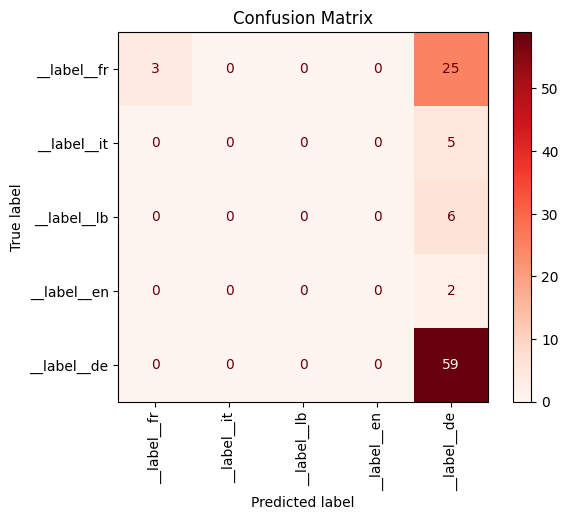


Detailed Classification Report:

              precision    recall  f1-score   support

 __label__fr       1.00      0.11      0.19        28
 __label__it       0.00      0.00      0.00         5
 __label__lb       0.00      0.00      0.00         6
 __label__en       0.00      0.00      0.00         2
 __label__de       0.61      1.00      0.76        59

    accuracy                           0.62       100
   macro avg       0.32      0.22      0.19       100
weighted avg       0.64      0.62      0.50       100



In [68]:
evaluate_model(model,test_data)

# Verbessern des Modells
Verbessern des Modells: Z.B. mehr Epochen, mehr Dimensionen, längere Buchstaben-N-Gramme, ...

Wichtigste Parameter:
```
   epoch N  # Beim Lernen wird das ganze Trainingsset N mal benutzt. Beeinflusst die Dauer des Trainings linear!
   dim N    # Länge der gelernten Vektoren für Wörter und Buchstaben-N-Gramme
   lr 0.N   # Initiale Lernrate: Bestimmt, wie stark die Vektoren verändert werden, wenn Fehler passieren. Während des Lernens wird die Lernrate immer kleiner.
   mmin N   # Minimale Länge der Subwords, d.h. Buchstaben-N-Gramme
   maxn N   # Maximale Länger der Subwords, d.h. Buchstaben-N-Gramme (falls N=0, werden keine Subwords benutzt, nur Wörter)
```

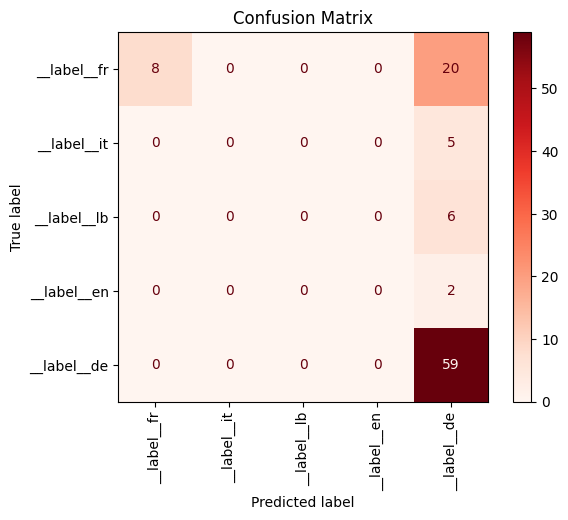


Detailed Classification Report:

              precision    recall  f1-score   support

 __label__fr       1.00      0.29      0.44        28
 __label__it       0.00      0.00      0.00         5
 __label__lb       0.00      0.00      0.00         6
 __label__en       0.00      0.00      0.00         2
 __label__de       0.64      1.00      0.78        59

    accuracy                           0.67       100
   macro avg       0.33      0.26      0.25       100
weighted avg       0.66      0.67      0.59       100



In [69]:
model = fasttext.train_supervised(
    input='impresso-lid-train.tsv',
    epoch=10,  # Wie oft werden die Trainingsdaten benutzt
    minn=2,    # Minimale Subword-Länge in Buchstaben
    maxn=2,    # Maximale Subword-Länge in Buchstaben
    dim=15,     # Dimensionalität der Vektoren für die Repräsentation der Wörter und Subwords
    lr=0.1     # Learning Rate (Lernrate): Wie stark wird ein Fehler bestraft?
    )
evaluate_model(model,test_data)

# LID Mini-Shared-Task
Arbeitet in Zweiergruppen und versucht, ein besseres Modell zu trainieren. Tragt die beste Konfiguration im Spreadsheet https://cutt.ly/casdmit-fs21-lid ein.

 - Reflexion: Welche Hyperparameter scheinen keinen wesentlichen Einfluss zu haben? Welche den grössten Einfluss?